We are making clusters out of the embedded data. These clusters represent the data of each individual for categorization purposes

In [ ]:
from utils import save_face_list, extract_frames
from face_extraction import process_image, check_face
from facenet_pytorch import MTCNN
import torch
import cv2
from main_extract_faces import process_movies
from main_unsupervised import find_best_number_of_clusters
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import os
import shutil
import plots
import augmentation
import main_embed
import cluster_dataframe
import embed



## Video File Handling Code Explanation

This code snippet is responsible for loading and verifying the accessibility of a specific video file using OpenCV (`cv2`).

In [ ]:
#Make sure you are in the right directory
os.getcwd()

In [ ]:
# Input and output file extensions for video files and images
input_extension = '.mp4'
output_extension = '.png'
samples_per_second = 10
padding_x = 10
padding_y = 10
min_confidence = 0.5

# List of movie names for training and testing
MOVIE_TRAINING_LIST = ['New_Kids_ABC', 'New_Kids_Fussballspiel', 
                       'New_Kids_Turbo_Tankstation', 'New_Kids_Nitro_Peter_lemonade_720']
MOVIE_TEST_LIST = ['Test']

# Movie folder (unchanged, retains absolute path)
MOVIE_FOLDER = "C:\\Users\\ningw\\Desktop\\"  # Path where video files are stored

# Define current directory variable
current_directory = os.getcwd()  # Dynamically set to the current working directory

# Define paths using the current directory variable
FACES_FOLDER_TRAINING = f"{current_directory}\\face_folder\\"
FACES_FOLDER_TEST = f"{current_directory}\\face_folder_test\\"

OUTPUT_FOLDER_RESULTS_TRAIN = f"{current_directory}\\results"
RESULTS_NAME_TRAIN = "results.csv"
RESULTS_CSV_TRAIN = f"{OUTPUT_FOLDER_RESULTS_TRAIN}\\results.csv"

OUTPUT_FOLDER_RESULTS_TEST = f"{current_directory}\\results_test"
RESULTS_NAME_TEST = "test_results.csv"
RESULTS_CSV_TEST = f"{OUTPUT_FOLDER_RESULTS_TEST}\\test_results.csv"

KMEANS_OUTPUT_FOLDER = f"{current_directory}\\KMEANS_OUTPUT\\"
CLUSTER_MODEL_PATH = f"{KMEANS_OUTPUT_FOLDER}\\kmeans.pkl"

# List of all directories
directories = [FACES_FOLDER_TRAINING, FACES_FOLDER_TEST, 
               OUTPUT_FOLDER_RESULTS_TRAIN, OUTPUT_FOLDER_RESULTS_TEST, 
               KMEANS_OUTPUT_FOLDER]

# Check if each directory exists, and create it if it doesn't
for path in directories:
    if not os.path.isdir(path):  # Check if the directory exists
        os.makedirs(path, exist_ok=True)  # Create the directory if it doesn't exist
        print(f"Checked/Created directory: {path}")  # Confirm creation of the directory
    else:
        print(f"Directory already exists: {path}")  # Confirm the directory already exists

## Video File Handling Code Explanation

This code snippet is responsible for loading and verifying the accessibility of a specific video file using OpenCV (`cv2`).

In [ ]:
# OpenCV's VideoCapture is initialized with the path to a video file.
cap = cv2.VideoCapture(MOVIE_FOLDER + MOVIE_TRAINING_LIST[1] + '.mp4')  # Construct the full file path using MOVIE_FOLDER and the second video name in the list.

# Check if the video file has been successfully opened.
if not cap.isOpened():  # .isOpened() returns False if the video file cannot be accessed.
    print("Error: Cannot open video file.")  # Print an error message if the video file cannot be opened.
else:
    print("Video file opened successfully!")  # Print a success message if the video file is opened correctly.

# Release the resources associated with the VideoCapture object.
cap.release()  # It's important to release the VideoCapture object to free resources and avoid memory leaks.

In [ ]:
# Call the function using the defined variables
process_movies(
    movie_list=MOVIE_TRAINING_LIST,
    movie_folder=MOVIE_FOLDER,
    faces_folder=FACES_FOLDER_TRAINING,
    input_extension=input_extension,
    output_extension=output_extension,
    samples_per_second=samples_per_second,
    padding_x=padding_x,
    padding_y=padding_y,
    min_confidence=min_confidence
)


In [ ]:
main_embed.embed(FACES_FOLDER_TRAINING, OUTPUT_FOLDER_RESULTS_TRAIN,RESULTS_NAME_TRAIN)

In [ ]:
best_clusters_silhouette, best_clusters_calinski = find_best_number_of_clusters(RESULTS_CSV_TRAIN)
cluster_choice = best_clusters_calinski

In [ ]:
# Function call for testing movies
process_movies(
    movie_list=MOVIE_TEST_LIST,
    movie_folder=MOVIE_FOLDER,
    faces_folder=FACES_FOLDER_TEST,
    input_extension=input_extension,
    output_extension=output_extension,
    samples_per_second=samples_per_second,
    padding_x=padding_x,
    padding_y=padding_y,
    min_confidence=min_confidence
)


In [ ]:
main_embed.embed(FACES_FOLDER_TEST,OUTPUT_FOLDER_RESULTS_TEST,RESULTS_NAME_TEST)

In [ ]:
train_embeddings_df = pd.read_csv(RESULTS_CSV_TRAIN)
trains_embeddings = train_embeddings_df.T.values
test_embeddings_df = pd.read_csv(RESULTS_CSV_TEST)
test_embeddings = test_embeddings_df.T.values

kmeans = KMeans(random_state=0, n_clusters=cluster_choice).fit(trains_embeddings)
labels = kmeans.labels_

distances_train = pairwise_distances_argmin_min(trains_embeddings, kmeans.cluster_centers_)[1]
threshold_distance_85 = np.percentile(distances_train, 85)

plots.plot_histplot_percentile(distances_train, threshold_distance_85)

for i, file_name in enumerate(train_embeddings_df.columns):
    if distances_train[i] > threshold_distance_85:
        train_embeddings_df.drop(file_name, axis='columns', inplace=True)
    
trains_embeddings = train_embeddings_df.T.values
kmeans = KMeans(random_state=0, n_clusters=cluster_choice, max_iter=600).fit(trains_embeddings)
labels = kmeans.labels_

for i, file_name in enumerate(train_embeddings_df.columns):
    src_path = os.path.join(FACES_FOLDER_TRAINING, file_name)
    if distances_train[i] > threshold_distance_85:
        dst_path = os.path.join(KMEANS_OUTPUT_FOLDER, 'outliers', file_name)
    else:   
        dst_path = os.path.join(KMEANS_OUTPUT_FOLDER, f'cluster_{labels[i]}', file_name)
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    shutil.copy(src_path, dst_path)
    


In [ ]:
thresholds = [0.80, 0.85, 0.9, 0.95]
for threshold in thresholds:
    # Calculate the threshold distance for the current percentile
    threshold_distance = np.percentile(distances_train, threshold * 100)      
    clusterdf = cluster_dataframe.process_videos_to_dataframe(MOVIE_TEST_LIST,MOVIE_FOLDER,kmeans, threshold_distance_85=threshold_distance)
    plots.plot_cluster_presence(clusterdf.sort_index(ascending=False)) 


In [ ]:
#Maakt de augmentations
augmentation.process_images_with_augmentations(FACES_FOLDER_TEST,'AUGMENTED')


In [ ]:
#Maakt van iedere folder met augmentation nieuwe embeddings
for folder_name in os.listdir('AUGMENTED'):
    folder_path = os.path.join('AUGMENTED', folder_name,'')
    if os.path.isdir(folder_path):
        # Dynamically construct paths
        AUGMENTED_FOLDERS = folder_path
        RESULT_NAME_TRAIN = f'embed_{folder_name}.csv'

        # Print paths for debugging
        print(f"Processing folder: {AUGMENTED_FOLDERS}")
        print(f"Output folder: {OUTPUT_FOLDER_RESULTS_TEST}")
        print(f"Result file: {RESULT_NAME_TRAIN}")

        # Call embedding function (example)
        main_embed.embed(AUGMENTED_FOLDERS, OUTPUT_FOLDER_RESULTS_TEST, RESULT_NAME_TRAIN)


In [ ]:
thresholds = [0.80, 0.85, 0.9, 0.95]
for threshold in thresholds:
    # Calculate the threshold distance for the current percentile
    threshold_distance = np.percentile(distances_train, threshold * 100)
    
    # Process the test embeddings with the current threshold
    results_df = cluster_dataframe.process_test_embeddings(
        test_embeddings=test_embeddings,
        test_embeddings_df=test_embeddings_df,
        kmeans=kmeans,
        output_folder='recognition-output',
        face_folder_test='face_folder_test',
        threshold=threshold_distance,
        results_output_path = f'test_results_{threshold}.csv',
    )
    
    # Plot actor presence
    plots.plot_actor_presence(results_df, 'Cluster', cluster_choice,f'test_results_{threshold}.csv')


Processing file: embed_brightness_contrast.csv
Index(['Test_0_brightness_contrast.jpg', 'Test_100_brightness_contrast.jpg',
       'Test_101_brightness_contrast.jpg', 'Test_102_brightness_contrast.jpg',
       'Test_103_brightness_contrast.jpg', 'Test_104_brightness_contrast.jpg',
       'Test_105_brightness_contrast.jpg', 'Test_106_brightness_contrast.jpg',
       'Test_107_brightness_contrast.jpg', 'Test_108_brightness_contrast.jpg',
       ...
       'Test_91_brightness_contrast.jpg', 'Test_92_brightness_contrast.jpg',
       'Test_93_brightness_contrast.jpg', 'Test_94_brightness_contrast.jpg',
       'Test_95_brightness_contrast.jpg', 'Test_96_brightness_contrast.jpg',
       'Test_97_brightness_contrast.jpg', 'Test_98_brightness_contrast.jpg',
       'Test_99_brightness_contrast.jpg', 'Test_9_brightness_contrast.jpg'],
      dtype='object', length=185)


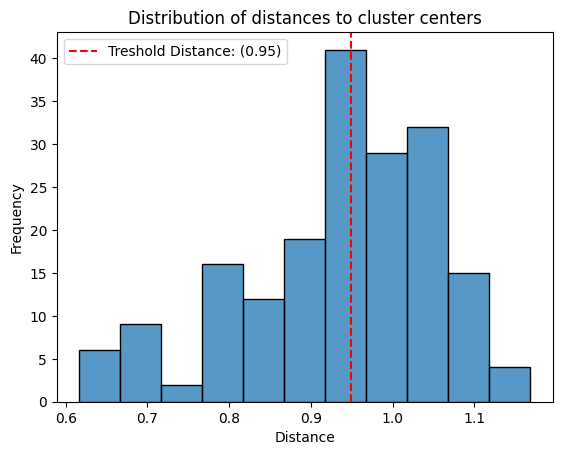

Image Test_0_brightness_contrast.jpg belongs to Cluster 1
Image Test_100_brightness_contrast.jpg belongs to Cluster 1
Image Test_101_brightness_contrast.jpg belongs to Cluster -1
Image Test_102_brightness_contrast.jpg belongs to Cluster -1
Image Test_103_brightness_contrast.jpg belongs to Cluster 1
Image Test_104_brightness_contrast.jpg belongs to Cluster 0
Image Test_105_brightness_contrast.jpg belongs to Cluster 0
Image Test_106_brightness_contrast.jpg belongs to Cluster 0
Image Test_107_brightness_contrast.jpg belongs to Cluster 0
Image Test_108_brightness_contrast.jpg belongs to Cluster 0
Image Test_109_brightness_contrast.jpg belongs to Cluster 0
Image Test_10_brightness_contrast.jpg belongs to Cluster 0
Image Test_110_brightness_contrast.jpg belongs to Cluster 0
Image Test_111_brightness_contrast.jpg belongs to Cluster 0
Image Test_112_brightness_contrast.jpg belongs to Cluster 0
Image Test_113_brightness_contrast.jpg belongs to Cluster 0
Image Test_114_brightness_contrast.jpg be

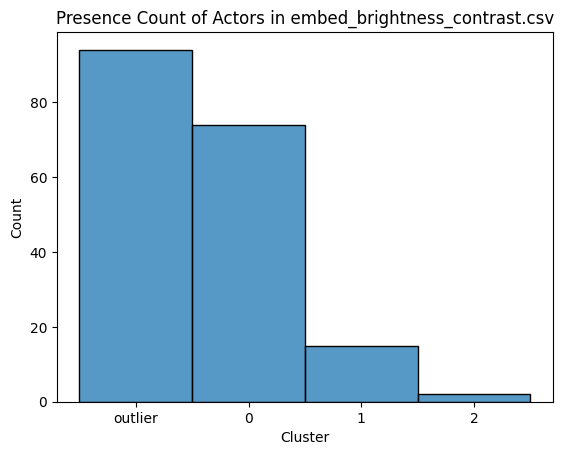

Processing file: embed_cutout.csv
Index(['Test_0_cutout.jpg', 'Test_100_cutout.jpg', 'Test_101_cutout.jpg',
       'Test_102_cutout.jpg', 'Test_103_cutout.jpg', 'Test_104_cutout.jpg',
       'Test_105_cutout.jpg', 'Test_106_cutout.jpg', 'Test_107_cutout.jpg',
       'Test_108_cutout.jpg',
       ...
       'Test_91_cutout.jpg', 'Test_92_cutout.jpg', 'Test_93_cutout.jpg',
       'Test_94_cutout.jpg', 'Test_95_cutout.jpg', 'Test_96_cutout.jpg',
       'Test_97_cutout.jpg', 'Test_98_cutout.jpg', 'Test_99_cutout.jpg',
       'Test_9_cutout.jpg'],
      dtype='object', length=185)


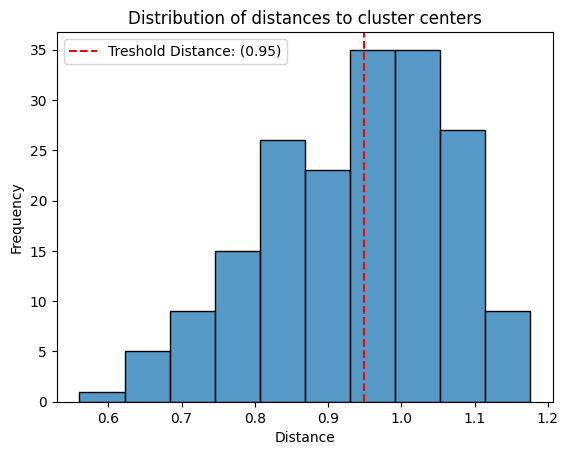

Image Test_0_cutout.jpg belongs to Cluster 1
Image Test_100_cutout.jpg belongs to Cluster 1
Image Test_101_cutout.jpg belongs to Cluster 1
Image Test_102_cutout.jpg belongs to Cluster 1
Image Test_103_cutout.jpg belongs to Cluster 1
Image Test_104_cutout.jpg belongs to Cluster 0
Image Test_105_cutout.jpg belongs to Cluster 0
Image Test_106_cutout.jpg belongs to Cluster 0
Image Test_107_cutout.jpg belongs to Cluster 0
Image Test_108_cutout.jpg belongs to Cluster -1
Image Test_109_cutout.jpg belongs to Cluster -1
Image Test_10_cutout.jpg belongs to Cluster 0
Image Test_110_cutout.jpg belongs to Cluster 0
Image Test_111_cutout.jpg belongs to Cluster -1
Image Test_112_cutout.jpg belongs to Cluster -1
Image Test_113_cutout.jpg belongs to Cluster -1
Image Test_114_cutout.jpg belongs to Cluster 0
Image Test_115_cutout.jpg belongs to Cluster -1
Image Test_116_cutout.jpg belongs to Cluster -1
Image Test_117_cutout.jpg belongs to Cluster -1
Image Test_118_cutout.jpg belongs to Cluster -1
Image T

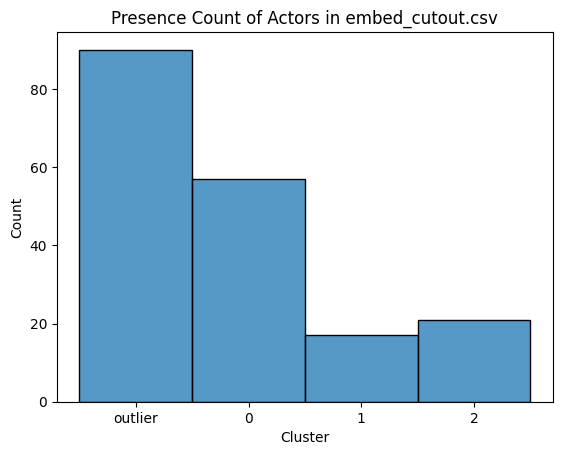

Processing file: embed_distortion.csv
Index(['Test_0_distortion.jpg', 'Test_100_distortion.jpg',
       'Test_101_distortion.jpg', 'Test_102_distortion.jpg',
       'Test_103_distortion.jpg', 'Test_104_distortion.jpg',
       'Test_105_distortion.jpg', 'Test_106_distortion.jpg',
       'Test_107_distortion.jpg', 'Test_108_distortion.jpg',
       ...
       'Test_91_distortion.jpg', 'Test_92_distortion.jpg',
       'Test_93_distortion.jpg', 'Test_94_distortion.jpg',
       'Test_95_distortion.jpg', 'Test_96_distortion.jpg',
       'Test_97_distortion.jpg', 'Test_98_distortion.jpg',
       'Test_99_distortion.jpg', 'Test_9_distortion.jpg'],
      dtype='object', length=185)


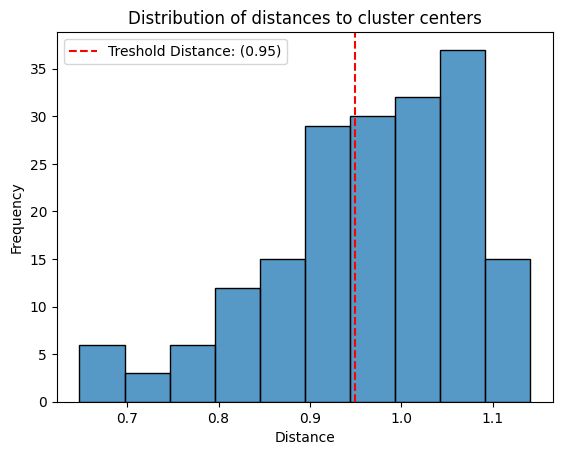

Image Test_0_distortion.jpg belongs to Cluster 1
Image Test_100_distortion.jpg belongs to Cluster 1
Image Test_101_distortion.jpg belongs to Cluster 1
Image Test_102_distortion.jpg belongs to Cluster -1
Image Test_103_distortion.jpg belongs to Cluster 1
Image Test_104_distortion.jpg belongs to Cluster 2
Image Test_105_distortion.jpg belongs to Cluster -1
Image Test_106_distortion.jpg belongs to Cluster -1
Image Test_107_distortion.jpg belongs to Cluster -1
Image Test_108_distortion.jpg belongs to Cluster -1
Image Test_109_distortion.jpg belongs to Cluster -1
Image Test_10_distortion.jpg belongs to Cluster -1
Image Test_110_distortion.jpg belongs to Cluster -1
Image Test_111_distortion.jpg belongs to Cluster -1
Image Test_112_distortion.jpg belongs to Cluster -1
Image Test_113_distortion.jpg belongs to Cluster -1
Image Test_114_distortion.jpg belongs to Cluster -1
Image Test_115_distortion.jpg belongs to Cluster -1
Image Test_116_distortion.jpg belongs to Cluster -1
Image Test_117_disto

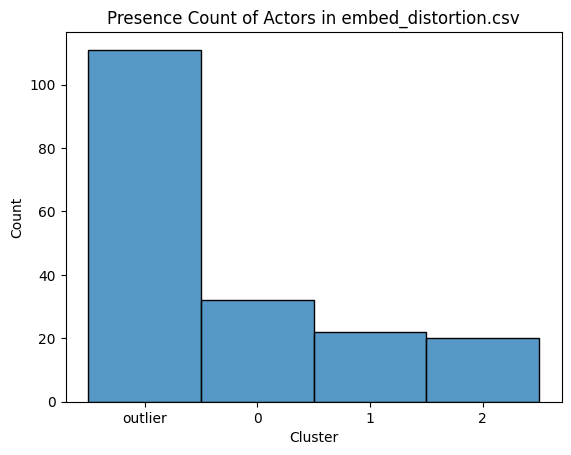

Processing file: embed_gaussian_noise.csv
Index(['Test_0_gaussian_noise.jpg', 'Test_100_gaussian_noise.jpg',
       'Test_101_gaussian_noise.jpg', 'Test_102_gaussian_noise.jpg',
       'Test_103_gaussian_noise.jpg', 'Test_104_gaussian_noise.jpg',
       'Test_105_gaussian_noise.jpg', 'Test_106_gaussian_noise.jpg',
       'Test_107_gaussian_noise.jpg', 'Test_108_gaussian_noise.jpg',
       ...
       'Test_91_gaussian_noise.jpg', 'Test_92_gaussian_noise.jpg',
       'Test_93_gaussian_noise.jpg', 'Test_94_gaussian_noise.jpg',
       'Test_95_gaussian_noise.jpg', 'Test_96_gaussian_noise.jpg',
       'Test_97_gaussian_noise.jpg', 'Test_98_gaussian_noise.jpg',
       'Test_99_gaussian_noise.jpg', 'Test_9_gaussian_noise.jpg'],
      dtype='object', length=185)


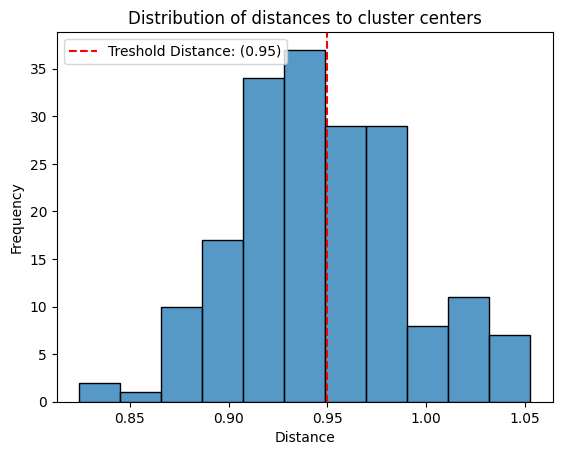

Image Test_0_gaussian_noise.jpg belongs to Cluster -1
Image Test_100_gaussian_noise.jpg belongs to Cluster 1
Image Test_101_gaussian_noise.jpg belongs to Cluster 1
Image Test_102_gaussian_noise.jpg belongs to Cluster 1
Image Test_103_gaussian_noise.jpg belongs to Cluster 1
Image Test_104_gaussian_noise.jpg belongs to Cluster 1
Image Test_105_gaussian_noise.jpg belongs to Cluster 1
Image Test_106_gaussian_noise.jpg belongs to Cluster 1
Image Test_107_gaussian_noise.jpg belongs to Cluster 1
Image Test_108_gaussian_noise.jpg belongs to Cluster 2
Image Test_109_gaussian_noise.jpg belongs to Cluster -1
Image Test_10_gaussian_noise.jpg belongs to Cluster 1
Image Test_110_gaussian_noise.jpg belongs to Cluster 1
Image Test_111_gaussian_noise.jpg belongs to Cluster 1
Image Test_112_gaussian_noise.jpg belongs to Cluster -1
Image Test_113_gaussian_noise.jpg belongs to Cluster 1
Image Test_114_gaussian_noise.jpg belongs to Cluster -1
Image Test_115_gaussian_noise.jpg belongs to Cluster 1
Image Tes

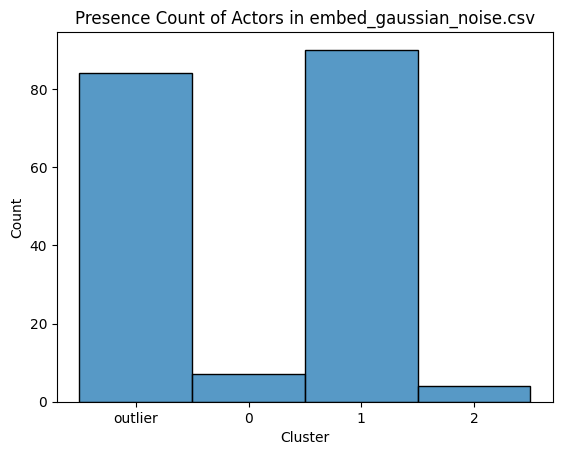

Processing file: embed_horizontal_flip.csv
Index(['Test_0_horizontal_flip.jpg', 'Test_100_horizontal_flip.jpg',
       'Test_101_horizontal_flip.jpg', 'Test_102_horizontal_flip.jpg',
       'Test_103_horizontal_flip.jpg', 'Test_104_horizontal_flip.jpg',
       'Test_105_horizontal_flip.jpg', 'Test_106_horizontal_flip.jpg',
       'Test_107_horizontal_flip.jpg', 'Test_108_horizontal_flip.jpg',
       ...
       'Test_91_horizontal_flip.jpg', 'Test_92_horizontal_flip.jpg',
       'Test_93_horizontal_flip.jpg', 'Test_94_horizontal_flip.jpg',
       'Test_95_horizontal_flip.jpg', 'Test_96_horizontal_flip.jpg',
       'Test_97_horizontal_flip.jpg', 'Test_98_horizontal_flip.jpg',
       'Test_99_horizontal_flip.jpg', 'Test_9_horizontal_flip.jpg'],
      dtype='object', length=185)


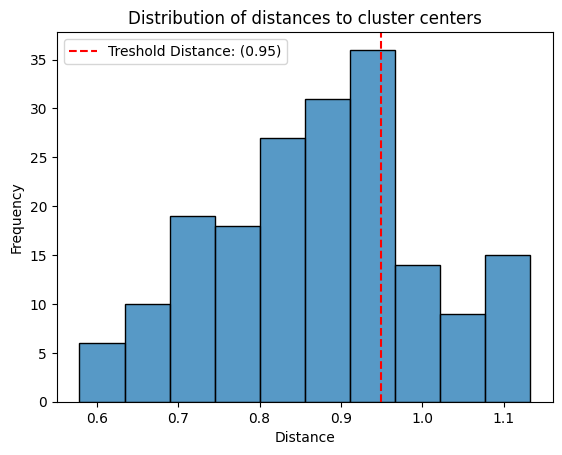

Image Test_0_horizontal_flip.jpg belongs to Cluster 1
Image Test_100_horizontal_flip.jpg belongs to Cluster 1
Image Test_101_horizontal_flip.jpg belongs to Cluster 1
Image Test_102_horizontal_flip.jpg belongs to Cluster 1
Image Test_103_horizontal_flip.jpg belongs to Cluster 1
Image Test_104_horizontal_flip.jpg belongs to Cluster 0
Image Test_105_horizontal_flip.jpg belongs to Cluster 0
Image Test_106_horizontal_flip.jpg belongs to Cluster 0
Image Test_107_horizontal_flip.jpg belongs to Cluster 0
Image Test_108_horizontal_flip.jpg belongs to Cluster 0
Image Test_109_horizontal_flip.jpg belongs to Cluster 0
Image Test_10_horizontal_flip.jpg belongs to Cluster 0
Image Test_110_horizontal_flip.jpg belongs to Cluster -1
Image Test_111_horizontal_flip.jpg belongs to Cluster -1
Image Test_112_horizontal_flip.jpg belongs to Cluster 0
Image Test_113_horizontal_flip.jpg belongs to Cluster 0
Image Test_114_horizontal_flip.jpg belongs to Cluster 0
Image Test_115_horizontal_flip.jpg belongs to Clu

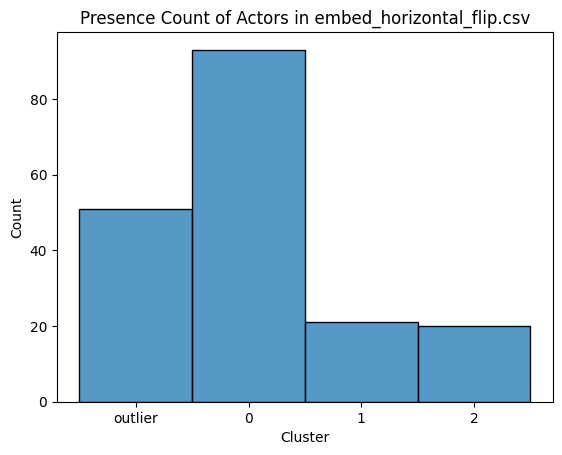

Processing file: embed_rotation.csv
Index(['Test_0_rotation.jpg', 'Test_100_rotation.jpg', 'Test_101_rotation.jpg',
       'Test_102_rotation.jpg', 'Test_103_rotation.jpg',
       'Test_104_rotation.jpg', 'Test_105_rotation.jpg',
       'Test_106_rotation.jpg', 'Test_107_rotation.jpg',
       'Test_108_rotation.jpg',
       ...
       'Test_91_rotation.jpg', 'Test_92_rotation.jpg', 'Test_93_rotation.jpg',
       'Test_94_rotation.jpg', 'Test_95_rotation.jpg', 'Test_96_rotation.jpg',
       'Test_97_rotation.jpg', 'Test_98_rotation.jpg', 'Test_99_rotation.jpg',
       'Test_9_rotation.jpg'],
      dtype='object', length=185)


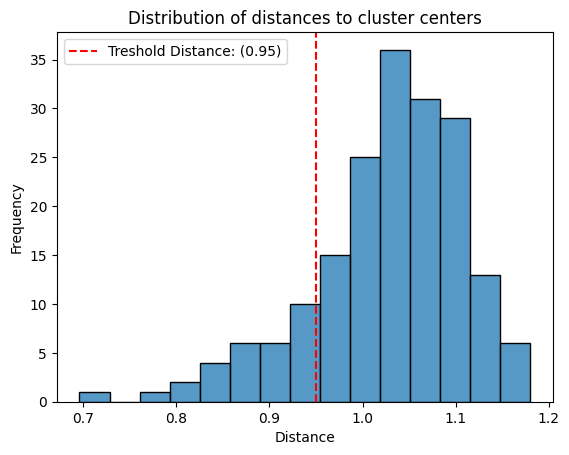

Image Test_0_rotation.jpg belongs to Cluster 1
Image Test_100_rotation.jpg belongs to Cluster 1
Image Test_101_rotation.jpg belongs to Cluster 1
Image Test_102_rotation.jpg belongs to Cluster -1
Image Test_103_rotation.jpg belongs to Cluster -1
Image Test_104_rotation.jpg belongs to Cluster -1
Image Test_105_rotation.jpg belongs to Cluster -1
Image Test_106_rotation.jpg belongs to Cluster -1
Image Test_107_rotation.jpg belongs to Cluster -1
Image Test_108_rotation.jpg belongs to Cluster -1
Image Test_109_rotation.jpg belongs to Cluster -1
Image Test_10_rotation.jpg belongs to Cluster -1
Image Test_110_rotation.jpg belongs to Cluster -1
Image Test_111_rotation.jpg belongs to Cluster -1
Image Test_112_rotation.jpg belongs to Cluster -1
Image Test_113_rotation.jpg belongs to Cluster -1
Image Test_114_rotation.jpg belongs to Cluster -1
Image Test_115_rotation.jpg belongs to Cluster -1
Image Test_116_rotation.jpg belongs to Cluster -1
Image Test_117_rotation.jpg belongs to Cluster -1
Image 

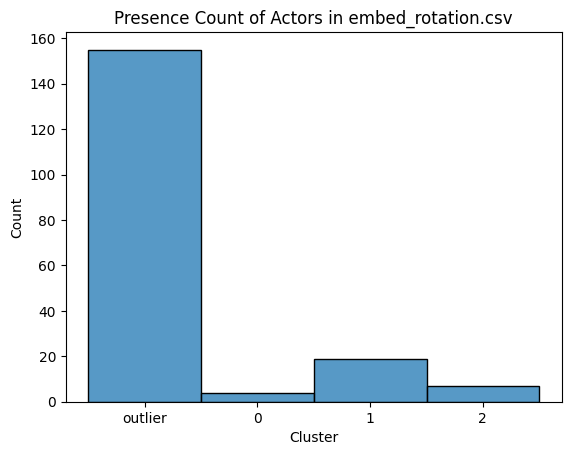

Processing file: test_results.csv
Index(['Test_0.png', 'Test_1.png', 'Test_10.png', 'Test_100.png',
       'Test_101.png', 'Test_102.png', 'Test_103.png', 'Test_104.png',
       'Test_105.png', 'Test_106.png',
       ...
       'Test_90.png', 'Test_91.png', 'Test_92.png', 'Test_93.png',
       'Test_94.png', 'Test_95.png', 'Test_96.png', 'Test_97.png',
       'Test_98.png', 'Test_99.png'],
      dtype='object', length=185)


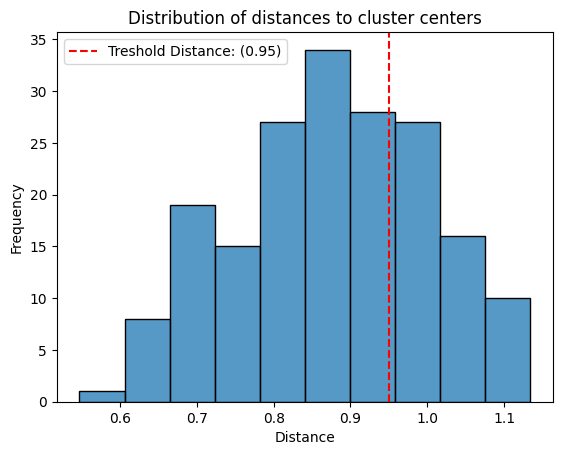

Image Test_0.png belongs to Cluster 1
Image Test_1.png belongs to Cluster 1
Image Test_10.png belongs to Cluster 0
Image Test_100.png belongs to Cluster 1
Image Test_101.png belongs to Cluster 1
Image Test_102.png belongs to Cluster 1
Image Test_103.png belongs to Cluster 1
Image Test_104.png belongs to Cluster 0
Image Test_105.png belongs to Cluster 0
Image Test_106.png belongs to Cluster 0
Image Test_107.png belongs to Cluster 0
Image Test_108.png belongs to Cluster 0
Image Test_109.png belongs to Cluster 0
Image Test_11.png belongs to Cluster 0
Image Test_110.png belongs to Cluster -1
Image Test_111.png belongs to Cluster -1
Image Test_112.png belongs to Cluster 0
Image Test_113.png belongs to Cluster -1
Image Test_114.png belongs to Cluster 0
Image Test_115.png belongs to Cluster -1
Image Test_116.png belongs to Cluster -1
Image Test_117.png belongs to Cluster -1
Image Test_118.png belongs to Cluster -1
Image Test_119.png belongs to Cluster 0
Image Test_12.png belongs to Cluster -1

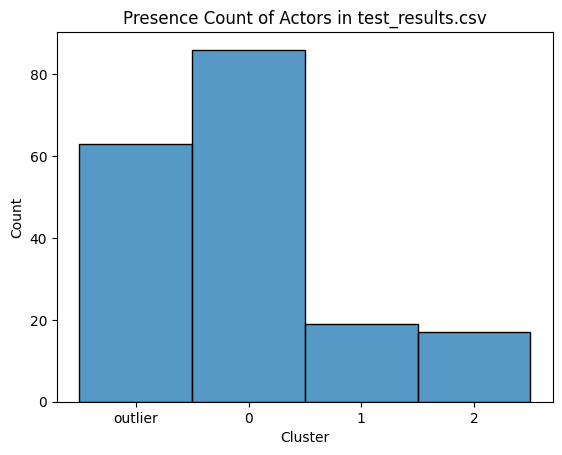

In [27]:
# Ensure the distorted_result directory exists 
os.makedirs("distorted_result", exist_ok=True)

#voor ieder embeddingbestand wordt clusterin gedaan, afstand bepaald en frequenty gedemonstreerd clustering distance 85
for file_name in os.listdir(OUTPUT_FOLDER_RESULTS_TEST):
    file_path = os.path.join(OUTPUT_FOLDER_RESULTS_TEST, file_name)
    
    # Check if it's a CSV file
    if file_name.endswith('.csv') and os.path.isfile(file_path):
        print(f"Processing file: {file_name}")
        
        # Read the embeddings from the CSV file
        test_embeddings_df = pd.read_csv(file_path)
        test_embeddings = test_embeddings_df.T.values
        print(test_embeddings_df.columns)
        # Process the embeddings and generate results
        results_df = cluster_dataframe.process_test_embeddings(
            test_embeddings=test_embeddings,
            test_embeddings_df=test_embeddings_df,
            kmeans=kmeans,
            output_folder='recognition-output',
            face_folder_test="face_folder_test",
            threshold=threshold_distance_85,
            results_output_path = f"distorted_result\\{file_name}",
        )
        
        # Plot actor presence
        plots.plot_actor_presence(results_df, 'Cluster', cluster_choice,file_name)